# 4/1(Mon) presentaion preparation

I used dispensaries/land area by zip code to calculate dispensaries "density" for plots.
 no conclusion so far...

* let me see how I can do stats more than just linear.
ANOVA the number of dispensaries by zipcode

In [35]:
# Dependencies
from census import Census
from us import states
from config import (census_key, gkey)
from scipy.stats import linregress
import statsmodels.api as sm

import gmaps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import time

# Census Data Retrieval

In [88]:
# Census API Key
c = Census(census_key, year=2017)
    # for labels, https://api.census.gov/data/2017/acs/acs5/groups.html
census_data = c.acs5.get(("NAME",
                          "B01002_001E", #Median Age
                          "B01003_001E", #Population
                        
                          "B02001_002E", #Race-White alone
                          "B02001_003E", #Race-Black or African American alone
                          "B02001_004E", #Race-American Indian and Alaska Native alone
                          "B02001_005E", #Race-Asian alone
                          "B02001_006E", #Race-Native Hawaiian and Other Pacific Islander alone
                          "B02001_007E", #Race-Some other race alone
                          "B03001_003E", #Hispanic or Latino
                          
                          "B09001_001E", #POPULATION UNDER 18 YEARS BY AGE
                          
                          "B15003_002E", #Education-No schooling completed
                          "B15003_017E", #Regular high school diploma
                          
                          "B17001_002E", #Poverty Count"
                         
                          "B19013_001E", #Median Household Income
                          "B19301_001E", #Per Capita Income
                          
                          "B23025_005E", #Unemployment Count FOR THE POPULATION 16 YEARS AND OVER
                          
                          "B25077_001E" #home Median value (dollars)
                         ), 
                         {'for': 'zip code tabulation area:*'}) #by all'zip code:*'

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df = census_df.rename(columns={"NAME": "Name",
                                      "B01002_001E": "Median Age",
                                      "B01003_001E": "Population",
                                      
                                      "B02001_002E": "Race-White",
                                      "B02001_003E": "Race-Black or African American",
                                      "B02001_004E": "Race-American Indian and Alaska Native",
                                      "B02001_005E": "Race-Asian",
                                      "B02001_006E": "Race-Native Hawaiian and Other Pacific Islander",
                                      "B02001_007E": "Race-Some other race",
                                      "B03001_003E": "Race-Hispanic or Latino",
                          
                                      "B09001_001E": "Pop under 18 YEARS BY AGE",
                          
                                      "B15003_002E": "Education-No schooling completed",
                                      "B15003_017E": "Education-Regular high school diploma",
                                      
                                      "B17001_002E": "Poverty Count",
                                      
                                      "B19013_001E": "Median Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      
                                      "B23025_005E": "Unemployment Count",
                                      
                                      "B25077_001E": "Home Median value (dollars)",
                                      "zip code tabulation area": "Zipcode"})
census_df.head()
census_df.to_csv("census_raw.csv", encoding="utf-8", index=False)

In [89]:
# Add in Race % columns (race / Population)
census_df["White(%)"] = 100 * census_df["Race-White"].astype(int) / census_df["Population"].astype(int)
census_df["Black or African American(%)"] = 100 * census_df["Race-Black or African American"].astype(int) / census_df["Population"].astype(int)
census_df["American Indian and Alaska Native(%)"] = 100 * census_df["Race-American Indian and Alaska Native"].astype(int) / census_df["Population"].astype(int)
census_df["Asian(%)"] = 100 * census_df["Race-Asian"].astype(int) / census_df["Population"].astype(int)
census_df["Native Hawaiian and Other Pacific Islander(%)"] = 100 * census_df["Race-Native Hawaiian and Other Pacific Islander"].astype(int) / census_df["Population"].astype(int)
census_df["Some other race(%)"] = 100 * census_df["Race-Some other race"].astype(int) / census_df["Population"].astype(int)
census_df["Hispanic or Latino(%)"] = 100 * census_df["Race-Hispanic or Latino"].astype(int) / census_df["Population"].astype(int)

# Add in Pop under 18 YEARS % column (Pop under 18 YEARS / Population)
census_df["Pop under 18yr(%)"] = 100 * census_df["Pop under 18 YEARS BY AGE"].astype(int) / census_df["Population"].astype(int)

# Add in Education % column (education level / Population)
census_df["No schooling completed(%)"] = 100 * census_df["Education-No schooling completed"].astype(int) / census_df["Population"].astype(int)
census_df["Regular high school diploma(%)"] = 100 * census_df["Education-Regular high school diploma"].astype(int) / census_df["Population"].astype(int)

# Add in Poverty Rate (Poverty Count / Population)
census_df["Poverty Rate"] = 100 * census_df["Poverty Count"].astype(int) / census_df["Population"].astype(int)

# Add in unemployment Rate (Employment Count / Population)
census_df["Unemployment Rate"] = 100 * census_df["Unemployment Count"].astype(int) / census_df["Population"].astype(int)

# Final DataFrame
census_df = census_df[["Name","Zipcode","Pop under 18yr(%)","Median Age","Population",
                       
                       "White(%)","Black or African American(%)",
                       "American Indian and Alaska Native(%)","Asian(%)",
                       "Native Hawaiian and Other Pacific Islander(%)","Some other race(%)",
                       "Hispanic or Latino(%)",
                       
                       "No schooling completed(%)","Regular high school diploma(%)",
                       
                       "Median Household Income","Per Capita Income",
                       "Poverty Rate","Unemployment Rate",
                      
                       "Home Median value (dollars)"]]
# Visualize
print(len(census_df))
census_df.head()

33120


,Name,Zipcode,Pop under 18yr(%),Median Age,Population,White(%),Black or African American(%),American Indian and Alaska Native(%),Asian(%),Native Hawaiian and Other Pacific Islander(%),Some other race(%),Hispanic or Latino(%),No schooling completed(%),Regular high school diploma(%),Median Household Income,Per Capita Income,Poverty Rate,Unemployment Rate,Home Median value (dollars)
0,ZCTA5 00601,00601,22.938803,38.9,17599.0,77.765782,0.681857,0.096596,0.000,0.000000,20.688675,99.624979,3.045628,16.091823,11757.0,7041.0,64.105915,13.943974,82500.0
1,ZCTA5 00602,00602,19.944401,40.9,39209.0,66.854549,2.785075,0.000000,0.000,0.000000,4.055191,93.692775,2.150017,13.813155,16190.0,8978.0,52.100283,6.473004,87300.0
2,ZCTA5 00603,00603,20.991323,40.4,50135.0,71.225691,3.959310,0.261295,1.111,0.019946,14.804029,97.466840,2.106313,16.926299,16645.0,10897.0,50.216416,7.156677,122300.0
3,ZCTA5 00606,00606,21.034264,42.8,6304.0,48.302665,2.538071,0.348985,0.000,0.000000,46.065990,99.809645,3.394670,19.225888,13387.0,5960.0,64.911168,3.236041,92700.0
4,ZCTA5 00610,00610,20.503806,41.4,27590.0,61.754259,3.062704,0.000000,0.000,0.003625,25.313519,97.317869,1.790504,18.865531,18741.0,9266.0,45.498369,5.342515,90300.0


In [107]:
census_df['Zipcode']=census_df['Zipcode'].astype(int)
census_df.to_csv("census_percent.csv", encoding="utf-8", index=False)
#census_df.dtypes

# merge census and zip code coordinates

In [108]:
# load coordinates of zipcode
us_zip_coords=pd.read_csv('2018_Gaz_zcta_national.csv')

census_w_coords=pd.merge(census_df,us_zip_coords, left_on='Zipcode', right_on='GEOID')
print(len(census_w_coords))

del census_w_coords['GEOID']
del census_w_coords['AWATER']
del census_w_coords['AWATER_SQMI']
census_w_coords.rename(columns={'ALAND':'Land Area (square meters)',
                        'ALAND_SQMI':'Land Area (square miles)',
                        'INTPTLAT': 'Lat',
                        'INTPTLONG':'Lng'},inplace=True)
census_w_coords.head()

33120


,Name,Zipcode,Pop under 18yr(%),Median Age,Population,White(%),Black or African American(%),American Indian and Alaska Native(%),Asian(%),Native Hawaiian and Other Pacific Islander(%),...,Regular high school diploma(%),Median Household Income,Per Capita Income,Poverty Rate,Unemployment Rate,Home Median value (dollars),Land Area (square meters),Land Area (square miles),Lat,Lng
0,ZCTA5 00601,601,22.938803,38.9,17599.0,77.765782,0.681857,0.096596,0.000,0.000000,...,16.091823,11757.0,7041.0,64.105915,13.943974,82500.0,166659749,64.348,18.180555,-66.749961
1,ZCTA5 00602,602,19.944401,40.9,39209.0,66.854549,2.785075,0.000000,0.000,0.000000,...,13.813155,16190.0,8978.0,52.100283,6.473004,87300.0,79307535,30.621,18.361945,-67.175597
2,ZCTA5 00603,603,20.991323,40.4,50135.0,71.225691,3.959310,0.261295,1.111,0.019946,...,16.926299,16645.0,10897.0,50.216416,7.156677,122300.0,81887185,31.617,18.455183,-67.119887
3,ZCTA5 00606,606,21.034264,42.8,6304.0,48.302665,2.538071,0.348985,0.000,0.000000,...,19.225888,13387.0,5960.0,64.911168,3.236041,92700.0,109579993,42.309,18.158327,-66.932928
4,ZCTA5 00610,610,20.503806,41.4,27590.0,61.754259,3.062704,0.000000,0.000,0.003625,...,18.865531,18741.0,9266.0,45.498369,5.342515,90300.0,93013427,35.913,18.295366,-67.125135


# For "FILTER" Merge : LA county's zip codes + census w/coords(2017)

In [109]:
# load LA county's zip codes.csv
LA_county_zipcodes= pd.read_csv('LA_county_zipcodes.csv', encoding='utf8')
#print(LA_county_zipcodes.head())
#print(LA_county_zipcodes.dtypes)
LA_county_zipcodes['zipcode']=LA_county_zipcodes['zipcode'].astype(int)

#Filter only LA county's data from census by merging
LA_county=pd.merge(LA_county_zipcodes,census_w_coords,how='left',left_on='zipcode',right_on='Zipcode')
del LA_county['Area Code(s)']
del LA_county['Classification']
del LA_county['Population_x']
del LA_county['Timezone']
del LA_county['Zipcode']
#LA_county['zipcode']=LA_county['zipcode'].astype(int)
#print(LA_county.dtypes)
print(len(LA_county))
LA_county.head()

282


,zipcode,City,Name,Pop under 18yr(%),Median Age,Population_y,White(%),Black or African American(%),American Indian and Alaska Native(%),Asian(%),...,Regular high school diploma(%),Median Household Income,Per Capita Income,Poverty Rate,Unemployment Rate,Home Median value (dollars),Land Area (square meters),Land Area (square miles),Lat,Lng
0,90001,Los Angeles,ZCTA5 90001,31.657530,28.7,58738.0,32.367462,9.164425,0.755899,0.224727,...,12.702169,35660.0,11882.0,31.757976,4.974633,305500.0,9071081,3.502,33.974026,-118.249510
1,90002,Los Angeles,ZCTA5 90002,32.111775,27.7,52856.0,37.683517,21.569926,0.879749,0.565688,...,13.877327,34000.0,11807.0,33.666944,5.032541,272400.0,7930602,3.062,33.949099,-118.246737
2,90003,Los Angeles,ZCTA5 90003,32.593276,28.2,70490.0,29.767343,22.383317,0.739112,0.285147,...,13.343737,34397.0,11305.0,32.929494,5.440488,300700.0,9197637,3.551,33.964131,-118.272783
3,90004,Los Angeles,ZCTA5 90004,19.396490,35.1,62733.0,37.758437,4.055282,0.170564,25.074522,...,13.361389,46581.0,30590.0,19.104777,4.182806,918500.0,7894527,3.048,34.076198,-118.310722
4,90005,Los Angeles,ZCTA5 90005,19.316516,35.4,39562.0,20.335170,6.228199,0.829078,34.823821,...,14.240938,32461.0,21566.0,28.562762,5.156463,713400.0,2807558,1.084,34.059163,-118.306892


In [110]:
LA_county.to_csv("LA_county_census.csv", encoding="utf-8", index=False)

## Marijuana Dispensaries

In [94]:
marijuana_df=pd.read_csv('CannabisLicData_cleaned.csv')
marijuana_df.head(3)

,License Number,License Type,Business Owner,Business Contact Information,Business Structure,Premise Address,CA,Zip Code,County_with leading space,County,Status,Issue Date,Expiration Date,Activities,Adult-Use/Medicinal
0,C10-0000010-LIC,Cannabis - Retailer License,KAREN KISSLER: KAREN KISSLER,"ALTERNATIVES, A HEALTH COLLECTIVE : ALTERNATI...",Corporation,1603 HAMPTON WAY SANTA ROSA,CA,95407,SONOMA,SONOMA,Active,3/19/2019,3/18/2020,N/A for this license type,BOTH
1,C10-0000009-LIC,Cannabis - Retailer License,John Swanston: John Swanston: Sean Eaddy,HORIZON NONPROFIT COLLECTIVE : Email- horizonc...,NaN,1841 EL CAMINO AVE SACRAMENTO,CA,95815,SACRAMENTO,SACRAMENTO,Active,1/31/2019,1/31/2020,N/A for this license type,BOTH
2,C10-18-0000287-TEMP,Cannabis - Retailer Temporary License,Angel Fernandez,MOVOCAN : Email- medigroupangel@gmail.com : Ph...,Corporation,1632 GATEWAY RD CALEXICO,CA,92231,IMPERIAL,IMPERIAL,Active,12/31/2018,7/29/2019,N/A for this license type,Medicinal


In [95]:
# count the number of dispensaries in each zipcode
marijuana_zip=marijuana_df['Zip Code'].value_counts()
# sort by index (zipcode)
marijuana_zip.sort_index(inplace=True)
# convert a series to a dataframe
marijuana_zip_df=pd.DataFrame(marijuana_zip)#columns='zipcode'
marijuana_zip_df.reset_index(inplace=True)
marijuana_zip_df=marijuana_zip_df.rename(columns={'index':'zipcode','Zip Code':'Count'})
marijuana_zip_df.dtypes
print(len(marijuana_zip_df))
marijuana_zip_df.head()

263


,zipcode,Count
0,90001,3
1,90007,1
2,90008,1
3,90012,1
4,90014,1


## Merge : LA county zipcode&census + #of marijuana dispensaries

In [114]:
N_marijuana_by_zipcode=pd.merge(LA_county,marijuana_zip_df, how='left', on='zipcode')

#print(N_marijuana_by_zipcode.head())
print(len(N_marijuana_by_zipcode))
#print(N_marijuana_by_zipcode['Count'].dtypes)

#convert NaN to 0 in 'Count'column
N_marijuana_by_zipcode['Count']=N_marijuana_by_zipcode['Count'].fillna(0)
N_marijuana_by_zipcode['Count'].value_counts()

#calculate count/land area
N_marijuana_by_zipcode['disps_density']=N_marijuana_by_zipcode['Count']/N_marijuana_by_zipcode['Land Area (square miles)']
N_marijuana_by_zipcode.head()

282


,zipcode,City,Name,Pop under 18yr(%),Median Age,Population_y,White(%),Black or African American(%),American Indian and Alaska Native(%),Asian(%),...,Per Capita Income,Poverty Rate,Unemployment Rate,Home Median value (dollars),Land Area (square meters),Land Area (square miles),Lat,Lng,Count,disps_density
0,90001,Los Angeles,ZCTA5 90001,31.657530,28.7,58738.0,32.367462,9.164425,0.755899,0.224727,...,11882.0,31.757976,4.974633,305500.0,9071081,3.502,33.974026,-118.249510,3.0,0.856653
1,90002,Los Angeles,ZCTA5 90002,32.111775,27.7,52856.0,37.683517,21.569926,0.879749,0.565688,...,11807.0,33.666944,5.032541,272400.0,7930602,3.062,33.949099,-118.246737,0.0,0.000000
2,90003,Los Angeles,ZCTA5 90003,32.593276,28.2,70490.0,29.767343,22.383317,0.739112,0.285147,...,11305.0,32.929494,5.440488,300700.0,9197637,3.551,33.964131,-118.272783,0.0,0.000000
3,90004,Los Angeles,ZCTA5 90004,19.396490,35.1,62733.0,37.758437,4.055282,0.170564,25.074522,...,30590.0,19.104777,4.182806,918500.0,7894527,3.048,34.076198,-118.310722,0.0,0.000000
4,90005,Los Angeles,ZCTA5 90005,19.316516,35.4,39562.0,20.335170,6.228199,0.829078,34.823821,...,21566.0,28.562762,5.156463,713400.0,2807558,1.084,34.059163,-118.306892,0.0,0.000000


In [115]:
N_marijuana_by_zipcode.to_csv('LA_county_census_disp_density.csv')

# Data cleaning

In [117]:
N_marijuana_clean=N_marijuana_by_zipcode.set_index('zipcode')
N_marijuana_clean.drop(index=[90071, 90073, 91330, 90263, #drop zip code 90071-hotel area,it lacks demographic data, 90073-VA Hospital
                              91046,90822, 90089], inplace=True) #91330-university and park, 90263-park, 91046-US postal service code
                                                            #90822-water treatment plant, 90089-USC school area
len(N_marijuana_clean)

275

In [118]:
N_marijuana_clean.to_csv('FOR_PLOT_N_marijuana_clean.csv')

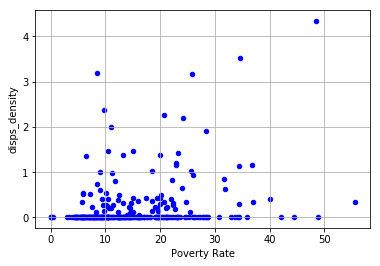

In [51]:
N_marijuana_by_zipcode.plot.scatter('Poverty Rate','disps_density',color='b' )
plt.grid()

In [ ]:
N_marijuana_by_zipcode.plot.scatter('Unemployment Rate','disps_density', color='r' )
plt.grid()

In [ ]:
# Set line
x_axis=N_marijuana_by_zipcode['Unemployment Rate']
y_axis=N_marijuana_by_zipcode['disps_density']
(slope, intercept, _, _, _) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept

# Plot data
fig, ax = plt.subplots()

fig.suptitle("Unemployment Rate vs. Dispensaries Density", fontsize=16, fontweight="bold")

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)

ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Dispensaries Density")

ax.plot(x_axis, y_axis, linewidth=0, marker='o')
ax.plot(x_axis, fit, 'b--', color='r')

plt.show()

In [ ]:
dropNA=N_marijuana_by_zipcode.dropna(subset=['Unemployment Rate','disps_density'])
len(dropNA)
(slope, intercept, _,_ , _) = linregress(dropNA['Unemployment Rate'],dropNA['disps_density'])
fit = slope * dropNA['Unemployment Rate'] + intercept

# Plot data
fig, ax = plt.subplots()

fig.suptitle("Unemployment Rate vs. Dispensaries Density", fontsize=16, fontweight="bold")

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)

ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Dispensaries Density")

ax.plot(dropNA['Unemployment Rate'], dropNA['disps_density'], linewidth=0, marker='o')
ax.plot(dropNA['Unemployment Rate'], fit, 'b--', color='mediumseagreen')

plt.show()

In [ ]:
crime=pd.read_csv('LA Arrest Data 2018_Clean.csv')
crime.head()

In [ ]:
# Access maps with unique API key
gmaps.configure(api_key=gkey)

# use symbol layer to pinpoint the locations of dispensaries
crime_symbol=crime[['Lat','Lng']]
crime_layer=gmaps.symbol_layer(
                crime_symbol, 
                fill_color='rgba(100, 0, 0, 0.4)',
                stroke_color='rgba(150, 0, 0, 0.4)', 
                scale=2 )
fig = gmaps.figure()
fig.add_layer(crime_layer)
fig

# Google call for coordinates of dispensaries

In [ ]:
dropNA=N_marijuana_by_zipcode.dropna(subset=['Unemployment Rate','disps_density'])
len(dropNA)
(slope, intercept, _, _, _) = linregress(dropNA['Unemployment Rate'],dropNA['disps_density'])
fit = slope * dropNA['Unemployment Rate'] + intercept

# Plot data
fig, ax = plt.subplots()

fig.suptitle("Unemployment Rate vs. Dispensaries Density", fontsize=16, fontweight="bold")

#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)

ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Dispensaries Density")

ax.plot(dropNA['Unemployment Rate'], dropNA['disps_density'], linewidth=0, marker='o')
ax.plot(dropNA['Unemployment Rate'], fit, 'b--', color='mediumseagreen')

plt.show()

In [ ]:
# set up additional columns to hold information
marijuana_df['Latitude']=''
marijuana_df['Longitude']=''
marijuana_df.head()

In [ ]:
# test
# address='1603 HAMPTON WAY SANTA ROSA'
# target_url=('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(address,gkey)
# mari_coords=requests.get(target_url).json()
# print(json.dumps(mari_coords, indent=4, sort_keys=True))
# mari_coords["results"][0]["geometry"]["location"]["lat"]

In [ ]:
for index, row in marijuana_df.iterrows():
    address=row['Premise Address']
    target_url=('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(address,gkey)
    mari_coords=requests.get(target_url).json()
    try:
        marijuana_df.loc[index,'Latitude'] = mari_coords["results"][0]["geometry"]["location"]["lat"]
        marijuana_df.loc[index,'Longitude'] = mari_coords["results"][0]["geometry"]["location"]["lng"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")
marijuana_df.head()


In [ ]:
marijuana_df.to_csv('marijuana_dispensaries_w_coords.csv')

In [ ]:
# Access maps with unique API key
gmaps.configure(api_key=gkey)

# use symbol layer to pinpoint the locations of dispensaries
mari_disp_symbol=marijuana_df[['Latitude','Longitude']]
mari_disp_layer=gmaps.symbol_layer(
                mari_disp_symbol, 
                fill_color='rgba(0, 90, 0, 0.4)',
                stroke_color='rgba(0, 150, 0, 0.4)', 
                scale=2 )
fig = gmaps.figure()
fig.add_layer(mari_disp_layer)
fig

In [ ]:
# use symbol layer to pinpoint the locations of dispensaries
crime_symbol=crime[['Lat','Lng']]
crime_layer=gmaps.symbol_layer(
                crime_symbol, 
                fill_color='rgba(100, 0, 0, 0.4)',
                stroke_color='rgba(150,0, 0, 0.4)', 
                scale=2 )
fig = gmaps.figure()
fig.add_layer(crime_layer)
fig

In [ ]:
N_marijuana_by_zipcode['Unemployment Rate'].describe()

In [ ]:
#Heatmap
# Store latitude and longitude in locations
locations=N_marijuana_by_zipcode[['Lat','Lng']]

# weight as unemployment
unemployment=N_marijuana_by_zipcode['Unemployment Rate']


fig=gmaps.figure()
# layter
heat_layer=gmaps.heatmap_layer(locations, weights=unemployment, 
                               max_intensity=5,point_radius =8
                                 )
fig.add_layer(heat_layer)
fig

In [ ]:
fig=gmaps.figure()
fig.add_layer(mari_disp_layer)
fig.add_layer(heat_layer)
fig